In [1]:
%matplotlib inline

import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='False'
import matplotlib
import numpy as np
import jax
import ptitprince as pt
import jax.numpy as jnp
import sys
import seaborn as sns
import sklearn.pipeline
import sklearn.preprocessing
from tqdm import tqdm
from scipy.stats.qmc import LatinHypercube
import statsmodels.api as sm
import jaxopt

sys.path.append("core") 

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import RidgeCV

plt.style.use('matplotlibrc')
plt.rcParams['axes.formatter.useoffset'] = 'False'

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tetris_env import TetrisEnv


In [2]:
#env = gym.envs.make("BipedalWalker-v3", hardcore=False)
#env = gym.envs.make("Walker2d", exclude_current_positions_from_observation=False)
env = TetrisEnv(seed=0)

plt.style.use('matplotlibrc')

d = 640
nActions = 4
H = 40
Noff = 200

class LFAAgent:

    def __init__(self, seed=None, unif=False, proj=None):
        """
        initialize the coefficients theta and set hyper-parameters.
        """
        # The following are recommended hyper-parameters.

        # Initial learning rate: 0.01
        # Learning rate decay for each episode: 0.995
        # Minimum learning rate: 0.001
        # Initial epsilon for exploration: 0.5
        # Epsilon decay for each episode: 0.98
        if proj is None:
            self.w = np.zeros((640,))  # The weight vector to be learned
            self.d = 640
        else:
            self.w = np.zeros((proj.shape[0],))
            self.d = proj.shape[0]
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)
        self.wcheck = np.copy(self.w)
        self.wtilde = np.copy(self.w)
        self.unif = unif
        self.proj = proj
        
    def maxQ(self, state_game, state_piece, prec=None, lam=1, w=None, pess=False):
        a_candidates = np.vstack([[a_pos, a_rot] 
                              for a_pos in range(5) for a_rot in range(4)])
        phix = np.vstack([self.phi(state_game, state_piece, a_pos, a_rot) 
                for a_pos in range(5) for a_rot in range(4)])
        if w is None:
            w = self.w
        # search over actions
        if pess:
            lam = -lam
        scores = phix @ w
        if prec is not None:
            scores += lam*np.sqrt(np.diag(phix @ prec @ phix.T))
            
        return scores

    def select_action(self, state_game, state_piece, prec=None, lam=1):
        """
        This function returns an action for the agent to take.
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
        Returns:
            action_pos: a_{pos}, the position where the agent will put the next piece down
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down
        """
        
        # Please complete codes for choosing an action given the current state  
        """
        Hint: You may use epsilon-greedy for exploration. 
        With probability self.epsilon, choose an action uniformly at random;
        Otherwise, choose a greedy action based on the approximated Q values.
        Recall that the Q values are aprroximated by the inner product of the weight vector (self.theta) and the feature vector (self.phi). 
        """
        ### BEGIN SOLUTION
        # YOUR CODE HERE
        if self.unif:
            action_pos = self.rng.choice(5)
            action_rot = self.rng.choice(4)
        else:
            actions = np.argmax(self.maxQ(state_game, state_piece, prec=prec, lam=lam))
            #actions = np.argmax(np.array([self.w.T @ self.phi(state_game, state_piece, a_pos, a_rot) 
            #              for a_pos in range(5) for a_rot in range(4)]))
            action_pos = int(actions/4)
            action_rot = actions % 4
        ### END SOLUTION
        return action_pos, action_rot
    
    @staticmethod
    def rotate(p, action_rot):
        """
        Rotate the piece `p` clockwise.
        Args:
            - p: the piece
            - action_rot: clockwise rotation of the piece. 
                          action_rot = 0, 1, 2, or 3.
                          0 means no rotation.
        Returns:
            - a new piece after the rotation
        """
        while action_rot > 0:
            q = p >> 2
            p = (2 if p & 1 != 0 else 0) + (2 << 2 if p & 2 != 0 else 0) + (
                1 << 2 if q & 2 != 0 else 0) + (1 if q & 1 != 0 else 0)
            action_rot = action_rot - 1
        if p % (1 << 2) == 0:
            p >>= 2
        return p
    
    # For your reference, the following function is an example of the feature vector \phi(s,a)
    # You can directly use this function as \phi(s,a), or you can design your own.
    def phi(self, state_game, state_piece, action_pos, action_rot):
        """
        Implement the feature function phi(s, a)
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
            action_pos: a_{pos}, the position where the agent puts the next piece down in the current step
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down in the current step
        Returns:
            feature_vec: feature vector
        """
        feature_vec = np.zeros((640,))
        feature_s_vec = np.zeros((8,))
        h_row = np.unpackbits(np.array([state_game >> 6], dtype=np.uint8))
        l_row = np.unpackbits(np.array([state_game & 63], dtype=np.uint8))
        heights = h_row.astype(int) * 2 + (l_row - h_row == 1).astype(int)
        feature_s_vec[0] = np.max(heights)  # the height of the highest column
        feature_s_vec[1] = np.sum(h_row.astype(int) - l_row.astype(int) == 1)  # holes
        wells = 0
        for i in range(2, 8):
            if (i == 2 or heights[i] - heights[i - 1] < 0) and (i == 7 or heights[i + 1] - heights[i] > 0):
                wells += 1
        feature_s_vec[2] = wells  # wells

        for i in range(3, 8):
            feature_s_vec[i] = heights[i] - heights[i - 1]  # differences in height between neighboring columns

        piece_rotated = self.rotate(state_piece, action_rot)

        action = action_pos * 16 + piece_rotated
        feature_vec[action * 8:(action + 1) * 8] = feature_s_vec
        
        # Try projecting this feature map down to the 0-60th eigenvectors of prec or somethin
        if self.proj is not None:
            feature_vec = self.proj @ feature_vec

        return feature_vec


2024-07-25 06:00:54.834267: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-07-25 06:00:54.977033: W external/xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 11.12GiB (11945825897 bytes) by rematerialization; only reduced to 12.33GiB (13238670924 bytes), down from 12.33GiB (13238670924 bytes) originally


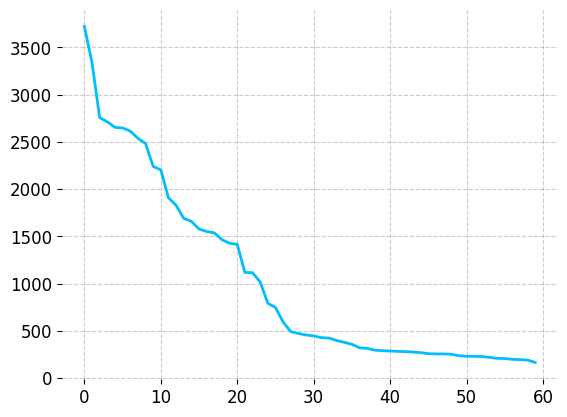

In [3]:
def collect_traj(env, agent, H):
    state_game, state_piece = env.reset()
    rewards = []
    phiX = []
    states = []
    actions = []
    nextstates = []
    for step in range(H):
        states.append(np.array([state_game, state_piece]))
        action_pos, action_rot = agent.select_action(state_game, state_piece)
        state_game, state_piece, reward = env.step(action_pos, action_rot)
        phix = agent.phi(state_game, state_piece, action_pos, action_rot)
        actions.append(np.array([action_pos, action_rot]))
        phiX.append(phix)
        rewards.append(reward)
        nextstates.append(np.array([state_game, state_piece]))
    return np.vstack(phiX), np.vstack(states), np.vstack(actions), np.array(rewards), np.vstack(nextstates)

def collect_dataset(env, agent, N, H):
    phiX = []
    rewards = []
    states = []
    actions = []
    nextstates = []
    for n in range(N):
        phi_traj, s_traj, a_traj, r_traj, sp_traj = collect_traj(env, agent, H)
        phiX.append(phi_traj[None,...])
        states.append(s_traj[None,...])
        actions.append(a_traj[None,...])
        nextstates.append(sp_traj[None,...])
        rewards.append(r_traj)
    return np.concatenate(phiX, axis=0), np.concatenate(states, axis=0),\
                np.concatenate(actions, axis=0), np.vstack(rewards), \
                np.concatenate(nextstates, axis=0)

phiX, states, actions, rewards, nextstates = collect_dataset(env, LFAAgent(unif=True), 1000, H)
dim_to_truncate_state_to = 60
Vts = jnp.linalg.svd(jnp.vstack(phiX), full_matrices=True)[2]
proj = Vts[:dim_to_truncate_state_to, :]

agent_bad = LFAAgent(proj=proj)
agent_bad.w = -np.load('data/ws_pess_hy.npy').mean(0)
phiX, states, actions, rewards, nextstates = collect_dataset(env, agent_bad, Noff, H)
d = proj.shape[0]

k = 5
Vts = jnp.linalg.svd(jnp.vstack(phiX), full_matrices=True)[2]
projOff = Vts[:k, :].T @ Vts[:k, :]
projOn = np.eye(d) - projOff
plt.plot(jnp.linalg.eigh(np.vstack(phiX).T @ np.vstack(phiX))[0].T[::-1])
plt.show()

In [4]:
phis = jnp.vstack(phiX)
cov = phis.T @ phis + np.eye(d)/H**2
prec = jnp.linalg.inv(cov)
np.diag(phis @ prec @ phis.T).mean()

0.007499899

In [5]:
phis[:,None,:].shape

(8000, 1, 60)

In [6]:
phis[:,None,...].shape

(8000, 1, 60)

In [7]:
(phis[...,None] @ phis[:,None,:]).shape

(8000, 60, 60)

In [8]:
phis[:10].shape

(10, 60)

In [9]:
phiX.min()

-3.9677591

In [10]:
net = jnp.array(np.random.uniform(-5, 5, np.vstack(phiX).shape))

@jax.jit
def xi_mat(prec):
    # vectorized batched quadratic form!
    return jax.grad(lambda prec : jax.scipy.special.logsumexp(net.dot(prec)*net) 
                )(prec)

xi = xi_mat(prec[:1000])

# mean loss for each feature

def explore_reward(feats, prec):
    xi = xi_mat(prec)
    return np.diagonal(xi[None,...] @ (feats[...,None] @ feats[:,None,:]), 0,1,2).mean(-1)

explore_reward(phis[:10], prec)

array([0.02280411, 0.00821318, 0.0226908 , 0.02384525, 0.02092993,
       0.02895666, 0.01942428, 0.01952962, 0.01931231, 0.02647312],
      dtype=float32)

In [ ]:
def lsvi(env, phiX, projOff, projOn, states, actions, rewards, nextstates, H, T, 
         agnostic=False, proj=proj, k=k, lam=1):
    d = phiX.shape[-1]
    w = np.random.uniform(-1,-1,size=d)
    errs = np.zeros((T, H))
    errs_off = np.zeros((T, H))
    errs_on = np.zeros((T, H))
    ws = np.zeros((T, H, d))
    n = phiX.shape[0]
    agent = LFAAgent(proj=proj)
    
    
    for t in tqdm(range(T)):
        # rollout under policy induced by w
        phi_traj, s_traj, a_traj, r_traj, sp_traj = \
                        collect_traj(env, agent, H)
        
        
        phix_full = np.vstack(phiX)
        prec = np.linalg.inv(phix_full.T @ phix_full + 0.01*np.eye(d))
        r_traj = explore_reward(phi_traj, prec)
        
        phiX = np.concatenate([phiX, phi_traj[None,...]], axis=0)
        rewards = np.concatenate([rewards, r_traj[None,...]], axis=0)
        actions = np.concatenate([actions, a_traj[None,...]], axis=0)
        states = np.concatenate([states, s_traj[None,...]], axis=0)
        nextstates = np.concatenate([nextstates, sp_traj[None,...]], axis=0)
        
        # bellman backups, save bellman errors
        for h in reversed(range(H)):
            # flatten N, H if MDP close to stationary
            if h != 0:
                err = 0
                err_off = 0
                err_on = 0
                continue
            else:
                phix = np.vstack(phiX[n:])
                phix_full = np.vstack(phiX)
                prec = np.linalg.inv(phix_full.T @ phix_full + 0.01*np.eye(d))
                Qp = np.array([np.max(agent.maxQ(sp[0], sp[1],
                                                 prec=prec, lam=1))
                                for sp in np.vstack(nextstates)]) #prec=prec
                w = prec @ phix_full.T @ (rewards.flatten()+Qp)
                projXoff = (projOff@phix[...,None]).squeeze(-1)
                projXon = (projOn@phix[...,None]).squeeze(-1)
                err = np.linalg.eigh(phix.T @ phix)[0][0]
                # 1/k-th largest, i.e. d-kth smallest eigenvalue
                err_off = np.linalg.eigh(projXoff.T @ projXoff)[0][d-k]
                # 1/(d-k)-th largest, i.e. kth-smallest eigenvalue
                err_on = np.linalg.eigh(projXon.T @ projXon)[0][k]
                
            agent.w = w
            ws[t,h] = w
            errs[t,h] = err
            errs_off[t,h] = err_off
            errs_on[t,h] = err_on
            #print('overall', err, 'min', min(err_off, err_on), 'off:', err_off, 'on:', err_on)
            
    return ws, errs, errs_off, errs_on, phiX, states, actions, rewards, nextstates


n_trials = 30
errs_hy_trials = []
errs_hy_off_trials = []
errs_hy_on_trials = []
errs_on_trials = []
errs_on_off_trials = []
errs_on_on_trials = []
errs_unif_trials = []
errs_unif_off_trials = []
errs_unif_on_trials = []


rewards_hy_trials = []
rewards_on_trials = []
rewards_unif_trials = []

phiX_hy_trials = []
states_hy_trials = []
actions_hy_trials = []
nextstates_hy_trials = []

phiX_on_trials = []
states_on_trials = []
actions_on_trials = []
nextstates_on_trials = []

phiX_unif_trials = []
states_unif_trials = []
actions_unif_trials = []
nextstates_unif_trials = []

for t in range(n_trials):
    
    phiX, states, actions, rewards, nextstates = collect_dataset(env, LFAAgent(unif=True, proj=proj), Noff, H)
    
    Vts = jnp.linalg.svd(jnp.vstack(phiX), full_matrices=True)[2]
    projOff = Vts[:k, :].T @ Vts[:k, :]
    projOn = np.eye(d) - projOff

    ws_unif, errs_unif, errs_off_unif, errs_on_unif, \
    phiX_unif, states_unif, actions_unif, rewards_unif, nextstates_unif = \
            lsvi(env, phiX, projOff, projOn, 
                 states, actions, rewards, nextstates, H, 100, agnostic=True, proj = proj, k=k,
                lam=0.1)
    
    phiX, states, actions, rewards, nextstates = collect_dataset(env, agent_bad, Noff, H)
    
    Vts = jnp.linalg.svd(jnp.vstack(phiX), full_matrices=True)[2]
    projOff = Vts[:k, :].T @ Vts[:k, :]
    projOn = np.eye(d) - projOff
    

    ws_hy, errs_hy, errs_off_hy, errs_on_hy, \
    phiX_hy, states_hy, actions_hy, rewards_hy, nextstates_hy = \
            lsvi(env, phiX, projOff, projOn, 
                 states, actions, rewards, nextstates, H, 100, agnostic=True, proj = proj, k=k,
                lam=0.1)
    
    ws_on, errs_on, errs_off_on, errs_on_on, phiX_on, states_on, actions_on, rewards_on, nextstates_on = \
            lsvi(env, phiX[:1], projOff, projOn, 
                 states[:1], actions[:1], rewards[:1], nextstates[:1], H, 300, agnostic=True, proj = proj, k=k,
                lam=0.1) # LAM WAS 0.1, 7:07pm Feb 29
    
    errs_hy_trials.append(errs_hy)
    errs_hy_off_trials.append(errs_off_hy)
    errs_hy_on_trials.append(errs_on_hy)
    errs_on_trials.append(errs_on)
    errs_on_off_trials.append(errs_off_on)
    errs_on_on_trials.append(errs_on_on)
    errs_unif_trials.append(errs_unif)
    errs_unif_off_trials.append(errs_off_unif)
    errs_unif_on_trials.append(errs_on_unif)
    
    rewards_hy_trials.append(rewards_hy)
    rewards_on_trials.append(rewards_on)
    rewards_unif_trials.append(rewards_unif)
    
    phiX_hy_trials.append(phiX_hy)
    states_hy_trials.append(states_hy)
    actions_hy_trials.append(actions_hy)
    nextstates_hy_trials.append(nextstates_hy)
    phiX_on_trials.append(phiX_on)
    states_on_trials.append(states_on)
    actions_on_trials.append(actions_on)
    nextstates_on_trials.append(nextstates_on)
    phiX_unif_trials.append(phiX_unif)
    states_unif_trials.append(states_unif)
    actions_unif_trials.append(actions_unif)
    nextstates_unif_trials.append(nextstates_unif)

 22%|██▏       | 22/100 [03:37<13:01, 10.01s/it]

In [ ]:
np.save('data/errs_hy.npy', np.array([np.array(errs_hy_trials), 
                                      np.array(errs_hy_off_trials), 
                                      np.array(errs_hy_on_trials)]))
np.save('data/errs_unif.npy', np.array([np.array(errs_unif_trials), 
                                        np.array(errs_unif_off_trials), 
                                        np.array(errs_unif_on_trials)]))
np.save('data/errs_on.npy', np.array([np.array(errs_on_trials), 
                                       np.array(errs_on_off_trials), 
                                       np.array(errs_on_on_trials)]))

In [6]:
errs_parts_unif = np.load('data/errs_unif.npy')
errs_parts_hy = np.load('data/errs_hy.npy')
errs_parts_on = np.load('data/errs_on.npy')[:, :, :100, :]
errs_parts_on.shape

(3, 30, 100, 40)

100%|██████████| 3/3 [00:00<00:00, 332.13it/s]


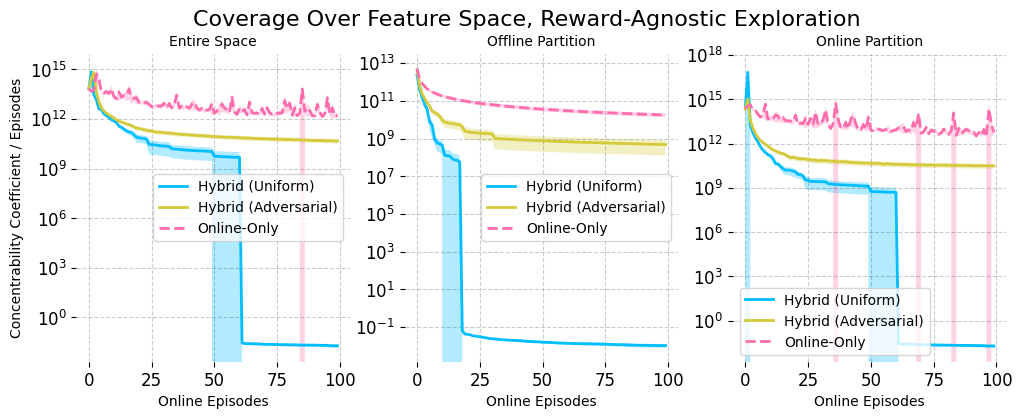

In [13]:
# EXPERIMENTAL, NON FIGURE OVERWRITING CELL

fig, ax = plt.subplots(1,3, figsize=(12,4))
errs_parts_unif = [np.array(errs_unif_trials), np.array(errs_unif_off_trials), np.array(errs_unif_on_trials)]
errs_parts_hy = [np.array(errs_hy_trials), np.array(errs_hy_off_trials), np.array(errs_hy_on_trials)]
errs_parts_on = [np.array(errs_on_trials)[:,:100,:], 
                 np.array(errs_on_off_trials)[:,:100,:], 
                 np.array(errs_on_on_trials)[:,:100,:]]
titles = ['Entire Space', 
          'Offline Partition', 
          'Online Partition']
for i in tqdm(range(3)):
    unif_arr = 1/np.abs(errs_parts_unif[i])[:,:,0]
    hy_arr = 1/np.abs(errs_parts_hy[i])[:,:,0]
    on_arr = 1/np.abs(errs_parts_on[i])[:,:,0]
    ax[i].plot(unif_arr.mean(0), linestyle='solid',
         label='Hybrid (Uniform)')
    ax[i].plot(hy_arr.mean(0), linestyle='solid',
         label='Hybrid (Adversarial)')
    ax[i].plot(on_arr.mean(0), linestyle='dashed',
         label='Online-Only')
    N = errs_parts_hy[0].shape[1]
    ax[i].fill_between(np.arange(N),
                       unif_arr.mean(0) - 1.96*unif_arr.std(0)/np.sqrt(N),
                       unif_arr.mean(0) + 1.96*unif_arr.std(0)/np.sqrt(N),
                       alpha=0.3)
    ax[i].fill_between(np.arange(N),
                       hy_arr.mean(0) - 1.96*hy_arr.std(0)/np.sqrt(N),
                       hy_arr.mean(0) + 1.96*hy_arr.std(0)/np.sqrt(N),
                       alpha=0.3)
    ax[i].fill_between(np.arange(N),
                       on_arr.mean(0) - 1.96*on_arr.std(0)/np.sqrt(N),
                       on_arr.mean(0) + 1.96*on_arr.std(0)/np.sqrt(N),
                       alpha=0.3)
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Episodes', fontsize=10, y=0.05)
    ax[i].set_yscale('log')
    #ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
    #ax[i].set_ylim(-0.4,100)
ax[0].set_ylabel('Concentrability Coefficient / Episodes', fontsize=10, x=0)

plt.suptitle('Coverage Over Feature Space, Reward-Agnostic Exploration', fontsize=16, y=0.99)
# higher UCB bonus
plt.savefig('figs/cov_agnostic_linear.png', dpi=300)

In [ ]:
def pevi(env, phiX, states, actions, rewards, nextstates, H, proj=proj, k=k, lam=1):
    d = phiX.shape[-1]
    w = np.zeros(d)#np.random.uniform(-1,-1,size=d)
    ws = np.zeros((H, d))
    
    agent = LFAAgent(proj=proj)
    agent.w = w

    # bellman backups, save bellman errors
    for h in tqdm(reversed(range(H))):
        phix = phiX[:,h,:]
        prec = np.linalg.inv(phix.T @ phix + 0.01*np.eye(d))
        Qp = np.array([np.max(agent.maxQ(sp[0], sp[1],
                                         prec=prec, lam=1, pess=True))
                        for sp in nextstates[:,h,:]]) #prec=prec
        w = prec @ phix.T @ (rewards[:,h]+Qp)
        agent.w = w
        ws[h] = w

    return ws

ws_pess_hy_trials = [pevi(env, phiX_hy_trials[i],
             states_hy_trials[i], actions_hy_trials[i], 
                          rewards_hy_trials[i], nextstates_hy_trials[i], 
             H, proj=proj, k=k, lam=1) for i in tqdm(range(n_trials))]
ws_pess_on_trials = [pevi(env, phiX_on_trials[i],
             states_on_trials[i], actions_on_trials[i], 
                          rewards_on_trials[i], nextstates_on_trials[i], 
             H, proj=proj, k=k, lam=1) for i in tqdm(range(n_trials))]

#np.save('data/ws_pess_hy.npy',np.mean(ws_pess_hy_trials,0))

In [ ]:

phiX_pess_off_trials = []
rewards_pess_off_trials = []
for t in tqdm(range(n_trials)):
    #phiX, states, actions, rewards, nextstates = collect_dataset(
    #    env, LFAAgent(unif=True, proj=proj), Noff+100, H)
    
    phiX, states, actions, rewards, nextstates = collect_dataset(env, agent_bad, Noff+100, H)
    
    ws_pess_off = pevi(env, phiX,
             states, actions, 
                          rewards, nextstates, 
             H, proj=proj, k=k, lam=1)
    agent_pess_off = LFAAgent(proj=proj)
    agent_pess_off.w = ws_pess_off.mean(0)

    phiX_pess_off,_,_, rewards_pess_off, _ = collect_dataset(env, agent_pess_off, Noff, H)
    
    phiX_pess_off_trials.append(phiX_pess_off)
    rewards_pess_off_trials.append(rewards_pess_off)

In [27]:
phiX_pess_hy_trials = []
rewards_pess_hy_trials = []
phiX_pess_on_trials = []
rewards_pess_on_trials = []

for t in tqdm(range(n_trials)):
    agent_pess_hy = LFAAgent(proj=proj)
    agent_pess_hy.w = ws_pess_hy_trials[t].mean(0)
    
    agent_pess_on = LFAAgent(proj=proj)
    agent_pess_on.w = ws_pess_on_trials[t].mean(0)

    phiX_pess_hy,_,_, rewards_pess_hy, _ = collect_dataset(env, agent_pess_hy, Noff, H)
    phiX_pess_on,_,_, rewards_pess_on, _ = collect_dataset(env, agent_pess_on, Noff, H)
    
    phiX_pess_hy_trials.append(phiX_pess_hy)
    rewards_pess_hy_trials.append(rewards_pess_hy)
    phiX_pess_on_trials.append(phiX_pess_on)
    rewards_pess_on_trials.append(rewards_pess_on)
    np.array(rewards_pess_hy_trials)

100%|██████████| 30/30 [09:26<00:00, 18.89s/it]


100%|██████████| 3/3 [00:00<00:00, 374.32it/s]


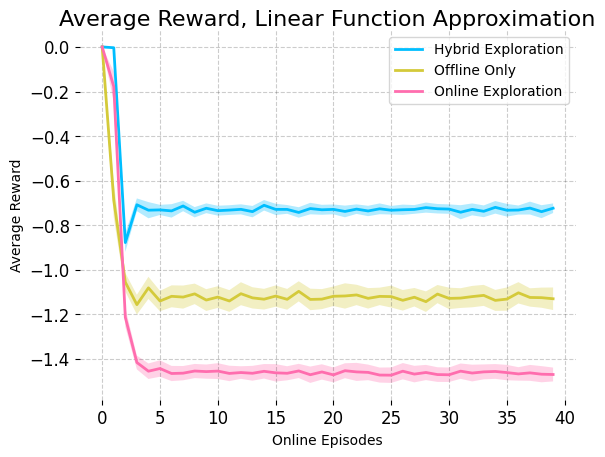

In [28]:
# EXPERIMENTAL, NON FIGURE OVERWRITING CELL

#fig, ax = plt.subplots(1,3, figsize=(12,4))
rewards_parts_hy = [np.array(rewards_pess_hy_trials), 
                 np.array(rewards_pess_off_trials), 
                 np.array(rewards_pess_on_trials)]
titles = ['Hybrid Exploration', 
          'Offline Only', 
          'Online Exploration']
for i in tqdm(range(3)):
    arr_mean = rewards_parts_hy[i].mean(1).mean(0)
    arr_std = rewards_parts_hy[i].mean(1).std(0)
    plt.plot(arr_mean, linestyle='solid',
         label=titles[i])
    N = rewards_parts_hy[0].shape[-1]
    plt.fill_between(np.arange(N),
                       arr_mean - 1.96*arr_std/np.sqrt(N),
                       arr_mean + 1.96*arr_std/np.sqrt(N),
                       alpha=0.3)
plt.xlabel('Online Episodes', fontsize=10, y=0.05)
#plt.yscale('log')
    #ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
plt.legend()
    #ax[i].set_ylim(-0.4,100)
plt.ylabel('Average Reward', fontsize=10, x=0)

plt.title('Average Reward, Linear Function Approximation', fontsize=16, y=0.99)
# higher UCB bonus
plt.savefig('figs/reward_agnostic_linear.png', dpi=300)

In [ ]:
np.array(rewards_pess_hy_trials).mean()

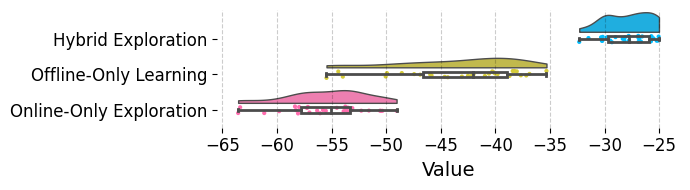

In [40]:

dx="group"; dy="score"; ort="h"; pal = "Set2"; sigma = 0.4
pal = sns.color_palette([tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4)) for h in ['00BEFF', 'D4CA3A', 'FF6DAE', '67E1B5', 'EBACFA', 
                                             '9E9E9E', 'F1988E', '5DB15A', 'E28544', '52B8AA']], 10)
titles = ['Hybrid Exploration', 
          'Offline-Only Learning', 
          'Online-Only Exploration']
fig, ax = plt.subplots(figsize=(7, 2))

ax=pt.RainCloud(x = 'variable', y = 'value', 
                data = pd.DataFrame(np.array(rewards_parts_hy).sum(-1).mean(-1), 
                                    index=titles).T.melt(), bw = sigma,
                palette=pal,
                 width_viol = 1.1, ax = ax, orient = ort)
plt.xlabel('Value')
plt.ylabel('')
plt.tight_layout()
plt.savefig('figs/reward_agnostic_value.png', dpi=300)

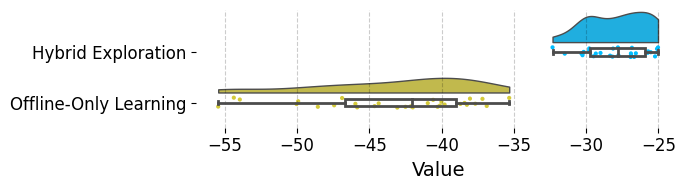

In [43]:

dx="group"; dy="score"; ort="h"; pal = "Set2"; sigma = 0.4
pal = sns.color_palette([tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4)) for h in ['00BEFF', 'D4CA3A', 'FF6DAE', '67E1B5', 'EBACFA', 
                                             '9E9E9E', 'F1988E', '5DB15A', 'E28544', '52B8AA']], 10)
titles = ['Hybrid Exploration', 
          'Offline-Only Learning', 
          'Online-Only Exploration']
fig, ax = plt.subplots(figsize=(7, 2))

ax=pt.RainCloud(x = 'variable', y = 'value', 
                data = pd.DataFrame(np.array(rewards_parts_hy).sum(-1).mean(-1)[:2], 
                                    index=titles[:2]).T.melt(), bw = sigma,
                palette=pal,
                 width_viol = 1.2, ax = ax, orient = ort)
plt.xlabel('Value')
plt.ylabel('')
plt.tight_layout()
plt.savefig('figs/reward_agnostic_value_condensed.png', dpi=300)

In [44]:
np.save('data/rewards_pess_hy.npy', np.array(rewards_pess_hy_trials))
np.save('data/rewards_pess_on.npy', np.array(rewards_pess_on_trials))
np.save('data/rewards_pess_off.npy', np.array(rewards_pess_off_trials))

In [ ]:
def optcov(env, phiX, projOff, projOn, states, actions, rewards, nextstates, H, K, T, 
         stationary=False, proj=proj, k=k, lam=1):
    return